# Overview

The purposes of this notebook is to create and evaluate models that classify an ICU patient as having or soon to have sepsis.
 
 __Methods__
 
    -Test/Train Split
    -Min Max Scaling 
    -Cross Leakage Prevention
    -Hyperparameter Estimation
    -Model Evaluation ROC Curves, Precision/Recall Curves, Classification Reports & Confusion Matrices
    -Plotting Feature Importance of Tree-Based Models
    -SMOTE (Synthetic Minority Oversampling Technique)
      
 __Results__
 
 The Logistic Regression, Decision Tree (Random Forest & Gradient Boost) and SVM models have very little skill in properly classifying patients, both in the sepsis and pre-sepsis stages. While the accuracy is high for classifying both sepsis and pre sepsis stages (>98%), the precision and recall for sepsis cases are low, typically with 5x as many false negatives and false positives compared to true positives. By far the most important feature in the tree models is ICU length of stay, so there does not seem to be clear patterns in the sepsis vs. non-sepsis patients in the data's current form. 
 
 As this data was apart of a competition, I sought the methods of other groups that were more successful in their model creation. As discussed in [this paper](https://arxiv.org/pdf/1910.06792.pdf), one group was able to build a model after heterogenous events embedding and attentional multihead aggregation. So better classification is possible, but methods more advanced than I am currently able to employ are needed.
 
  __Note__
  
  When the models were first created, only 15% of available data was used on accident. Upon applying all preprocessing steps to the new data, I re-ran the logistic regression and XGBoost models with no significant changes in performance. So I conclude that the extra data do not improve the models.

# Code Navigation
* [1. Import Libraries & Data](#1.ImportLibraries&Data)
* [2. Preventing Data Leakage](#2.PreventingDataLeakage)
* [3. Create Test & Train Sets](#3.CreateTest&TrainSets)
* [4. Apply Min/Max Scaler, Ensure CV has No Cross Leakage](#4.ApplyMin/MaxScaler,EnsureCVhasNoCrossLeakage)
* [5. Modeling](#5.Modeling)
    * [5.1. Dummy Classifier](#5.1.DummyClassifier)
    * [5.2. Logistic Regression](#5.2.LogisticRegression)
    * [5.3. Random Forest](#5.3.RandomForest)
    * [5.4. Gradient Boosting](#5.4.GradientBoosting)
    * [5.5. SVM](#5.5.SVM)
* [6. Modeling with SMOTE](#6.ModelingwithSMOTE)
    * [6.1. Logistic Regression - SMOTE](#6.1.LogisticRegression-SMOTE)
    * [6.2. Gradient Boosting - SMOTE](#6.2.GradientBoosting-SMOTE)
* [7. Modeling - All Data](#7.Modeling-AllData)
    * [7.1. Logistic Regression - All Data](#7.1.LogisticRegression-AllData)
    * [7.2. Gradient Boosting- All Data](#7.2.GradientBoosting-AllData)

# 1. Import Libraries & Data <a class="anchor" id="1.ImportLibraries&Data"></a>

In [1]:
#General Imports
import glob, os
import pandas as pd
import numpy as np
import json
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image
from scipy.stats import uniform
from datetime import datetime
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [2]:
#Sklearn imports
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC  
from sklearn.datasets import make_classification
from sklearn.metrics import plot_confusion_matrix, classification_report, \
roc_curve, plot_precision_recall_curve, precision_recall_curve, confusion_matrix, auc, plot_roc_curve
from sklearn.feature_selection import SelectFromModel

In [3]:
os.chdir("../src/data")
from time_elapsed import time_elapsed
from PlotPrecisionRecall import Plot_PR
from PlotFeatureImportance import Plot_Feat_Imp
from CreateJupyterNotebookHeadings import jupyternotebookheadings1, jupyternotebookheadings2

In [4]:
#Load in Data
os.chdir("../../data/processed")
df=pd.read_csv('sepsis_data_preprocessed.csv',index_col=0)

C:\Users\amcas\anaconda3\lib\site-packages\numpy\lib\arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [5]:
#Drop Unit/Hospital Identifying Variables
list_=['Unit1','Unit2','HospitalA']
df.drop(columns=list_,inplace=True)

In [6]:
#df_copy=df.copy()
#df=df_copy

# 2. Preventing Data Leakage <a class="anchor" id="2.PreventingDataLeakage"></a>

In [7]:
#Generate matrix with all patient id's randomly shuffled (id_shuff)
np.random.seed(seed=5)
id_shuff=df.id.unique()
np.random.shuffle(id_shuff)
#Split into test & train arrays of 1/4 and 3/4 the original size
n=int(round(id_shuff.size*0.25,0))
test_id=id_shuff[0:n]
train_id=id_shuff[n:]

In [8]:
#Calculate percent of time points in test df
a=round(len(df[df.id.isin(test_id)])/(len(df))*100,2)
print("The test data set has {}% of the data points".format(a))

The test data set has 24.83% of the data points


In [9]:
#Calculate percent of patients with sepsis in train df 
a=round(df[df.id.isin(train_id)].SepsisOnset.sum()/len(train_id)*100,2)
print("{}% of patients in the train data set have sepsis".format(a))

7.18% of patients in the train data set have sepsis


In [10]:
#Calculate percent of patients with sepsis in test df 
a=round(df[df.id.isin(test_id)].SepsisOnset.sum()/len(test_id)*100,2)
print("{}% of patients in the test data set have sepsis".format(a))

7.54% of patients in the test data set have sepsis


# 3. Create Test & Train Sets <a class="anchor" id="3.CreateTest&TrainSets"></a>

In [11]:
#Create Test/Train X
X_train=df[df.id.isin(train_id)].copy()
X_test=df[df.id.isin(test_id)].copy()

#Split y_train into various classification columns 
y_train_sepsis=X_train['SepsisLabel']
y_train_pre=X_train['Pre_Sepsis_Three']

#Split y_test into various classification columns 
y_test_sepsis=X_test['SepsisLabel']
y_test_pre=X_test['Pre_Sepsis_Three']

#Drop all classifiers from X
X_train.drop(columns=['SepsisLabel','SepsisOnset','id','Pre_Sepsis_Three'],inplace=True)
X_test.drop(columns=['SepsisLabel','SepsisOnset','id','Pre_Sepsis_Three'],inplace=True)

#Get Labels for later
Var_names=list(X_train.columns)

# 4. Apply Min/Max Scaler, Ensure CV has No Cross Leakage <a class="anchor" id="4.ApplyMin/MaxScaler,EnsureCVhasNoCrossLeakage"></a>

In [12]:
#Fit Min-Max Scaler to X_train data, transform X_train and X_test data
MM_scale=MinMaxScaler()
MM_scale.fit(X_train)
X_train=MM_scale.transform(X_train)
X_test=MM_scale.transform(X_test)

#Create kfolds CV object (to allow for sequential folding, not random - prevents data leakage in cross folds)
folds=KFold(n_splits=4)

# 5. Modeling <a class="anchor" id="5.Modeling"></a>

## 5.1. Dummy Classifier <a class="anchor" id="5.1.DummyClassifier"></a>

### Sepsis Label

In [13]:
#Model Sepsis Label - Dummy Classifier, Most Frequent
dummy_clf = DummyClassifier(strategy="most_frequent")
y_pred_dummy=dummy_clf.fit(X_train, y_train_sepsis).predict(X_test)
print(classification_report(y_test_sepsis,y_pred_dummy,zero_division=0))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99    378144
           1       0.00      0.00      0.00      7213

    accuracy                           0.98    385357
   macro avg       0.49      0.50      0.50    385357
weighted avg       0.96      0.98      0.97    385357



### Pre Sepsis

In [14]:
#Model Pre Sepsis - Dummy Classifier, Most Frequent
dummy_clf = DummyClassifier(strategy="most_frequent")
y_pred_dummy=dummy_clf.fit(X_train, y_train_pre).predict(X_test)
print(classification_report(y_test_pre,y_pred_dummy,zero_division=0))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    383455
           1       0.00      0.00      0.00      1902

    accuracy                           1.00    385357
   macro avg       0.50      0.50      0.50    385357
weighted avg       0.99      1.00      0.99    385357



## 5.2. Logistic Regression <a class="anchor" id="5.2.LogisticRegression"></a>

### Sepsis Label 

In [15]:
#Find logsitic regression parameters for modeling Sepsis Label
start = datetime.now()
clf = LogisticRegression(max_iter=10000)
C=[1/(10**i) for i in range(0,10)]
distributions = {'C': C}
LR_GS=GridSearchCV(clf,distributions,cv=folds.split(X_train),n_jobs=-1,scoring='f1')
search_LR_GS=LR_GS.fit(X_train, y_train_sepsis)
end = datetime.now()
time_elapsed(start,end)
best_dict=search_LR_GS.best_params_
search_LR_GS.best_params_

This process took 00 Hours 10 Minutes 38 Seconds 


{'C': 1.0}

In [19]:
#Find logsitic regression parameters for modeling Sepsis Label - with more tailored range of C values
start = datetime.now()
clf = LogisticRegression(max_iter=10000)
C=[round(0.1*i,2) for i in range(2,11)]
distributions = {'C': C}
LR_GS=GridSearchCV(clf,distributions,cv=folds.split(X_train),n_jobs=-1,scoring='f1')
search_LR_GS=LR_GS.fit(X_train, y_train_sepsis)
end = datetime.now()
time_elapsed(start,end)
best_dict=search_LR_GS.best_params_
search_LR_GS.best_params_

This process took 00 Hours 29 Minutes 58 Seconds 


{'C': 0.9}

In [20]:
#Make Logistic Regression Model with optimized C
clf=LogisticRegression(max_iter=1000,C=best_dict['C'])
clf.fit(X_train,y_train_sepsis)

LogisticRegression(C=0.9, max_iter=1000)

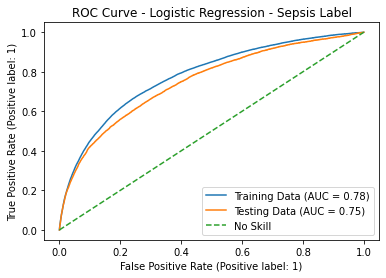

In [21]:
#Plot ROC Curve
_=plt.axes()
plot_roc_curve(clf,X_train,y_train_sepsis,ax=_,name='Training Data')
plot_roc_curve(clf,X_test,y_test_sepsis,ax=_,name='Testing Data')
_.plot([0,1],[0,1],label='No Skill',linestyle='--')
_.legend()
_.set_title('ROC Curve - Logistic Regression - Sepsis Label')
plt.show()

Best Train Threshold=0.580558, F-Score=nan
Best Test Threshold=0.070558, F-Score=0.159
Train AUC: 0.083 Test AUC: 0.079


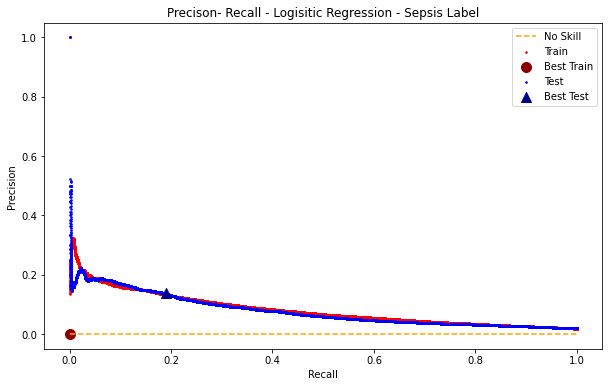

In [22]:
#Plot Precison-Recall Curve, determine optimal cutoff value
title='Precison- Recall - Logisitic Regression - Sepsis Label'
prob=Plot_PR(clf,X_train,y_train_sepsis,X_test,y_test_sepsis,title,auc,precision_recall_curve,np,plt,(10,6))

In [23]:
#Return Classification Report of testing data with optimal train probability threshold
q=clf.predict_proba(X_test)[:,1]
y_pred_test_new=[1 if i>prob else 0 for i in q]
print(classification_report(y_test_sepsis,y_pred_test_new))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99    378144
           1       0.25      0.00      0.00      7213

    accuracy                           0.98    385357
   macro avg       0.62      0.50      0.50    385357
weighted avg       0.97      0.98      0.97    385357



In [24]:
#Return Confusion Matrix of testing data with optimal train probability threshold
print(confusion_matrix(y_test_sepsis,y_pred_test_new))

[[378141      3]
 [  7212      1]]


### Pre Sepsis

In [25]:
#Find logsitic regression parameters for modeling Pre Sepsis
start = datetime.now()
clf = LogisticRegression(max_iter=10000)
C=[1/(10**i) for i in range(0,10)]
distributions = {'C': C}
LR_GS=GridSearchCV(clf,distributions,cv=folds.split(X_train),n_jobs=-1,scoring='f1')
search_LR_GS=LR_GS.fit(X_train, y_train_pre)
end = datetime.now()
time_elapsed(start,end)
best_dict=search_LR_GS.best_params_
search_LR_GS.best_params_

This process took 00 Hours 07 Minutes 40 Seconds 


{'C': 1.0}

In [26]:
#Find logsitic regression parameters for modeling Sepsis Label - with more tailored range of C values
start = datetime.now()
clf = LogisticRegression(max_iter=10000)
C=[round(0.1*i,2) for i in range(2,11)]
distributions = {'C': C}
LR_GS=GridSearchCV(clf,distributions,cv=folds.split(X_train),n_jobs=-1,scoring='f1')
search_LR_GS=LR_GS.fit(X_train, y_train_pre)
end = datetime.now()
time_elapsed(start,end)
best_dict=search_LR_GS.best_params_
search_LR_GS.best_params_

This process took 00 Hours 20 Minutes 03 Seconds 


{'C': 0.2}

In [27]:
#Make Logistic Regression Model with optimized C
clf_=LogisticRegression(max_iter=1000,C=best_dict['C'])
clf_.fit(X_train,y_train_pre)

LogisticRegression(C=0.2, max_iter=1000)

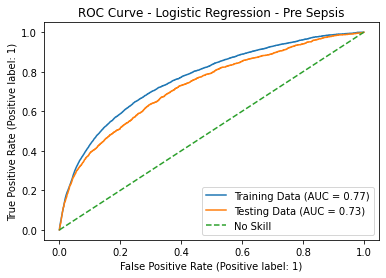

In [28]:
#Plot ROC Curve
_=plt.axes()
plot_roc_curve(clf_,X_train,y_train_pre,ax=_,name='Training Data')
plot_roc_curve(clf_,X_test,y_test_pre,ax=_,name='Testing Data')
_.plot([0,1],[0,1],label='No Skill',linestyle='--')
_.legend()
_.set_title('ROC Curve - Logistic Regression - Pre Sepsis')
plt.show()

Best Train Threshold=0.182348, F-Score=nan
Best Test Threshold=0.274590, F-Score=nan
Train AUC: 0.02 Test AUC: 0.019


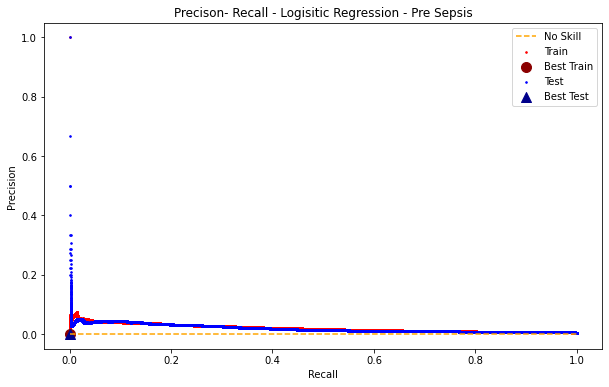

In [29]:
#Plot Precison-Recall Curve, determine optimal cutoff value
title='Precison- Recall - Logisitic Regression - Pre Sepsis'
prob=Plot_PR(clf_,X_train,y_train_pre,X_test,y_test_pre,title,auc,precision_recall_curve,np,plt,(10,6))

In [30]:
#Return Classification Report of testing data with optimal train probability threshold
q=clf_.predict_proba(X_test)[:,1]
y_pred_test_new=[1 if i>prob else 0 for i in q]
print(classification_report(y_test_pre,y_pred_test_new))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    383455
           1       0.12      0.00      0.01      1902

    accuracy                           0.99    385357
   macro avg       0.56      0.50      0.50    385357
weighted avg       0.99      0.99      0.99    385357



In [31]:
#Return Confusion Matrix of testing data with optimal train probability threshold
print(confusion_matrix(y_test_pre,y_pred_test_new))

[[383411     44]
 [  1896      6]]


## 5.3. Random Forest <a class="anchor" id="5.3.RandomForest"></a>

### Sepsis Label

In [ ]:
#Find optimal random forest parameters for modeling Sepsis Label
start = datetime.now()
RFC = RandomForestClassifier(random_state=42,max_features='sqrt',n_estimators=500)
max_depth = [x**2 for x in range(2,10)]
min_samples_split = [4,7,16]
min_samples_leaf = [4,7,16]
distributions = {'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}
RFC_RS=RandomizedSearchCV(RFC,distributions,random_state=42,n_iter=20,cv=folds.split(X_train),n_jobs=-1,scoring='f1')
search_RFC_Sepsis=RFC_RS.fit(X_train, y_train_sepsis)
best_dict=search_RFC_Sepsis.best_params_
end = datetime.now()
time_elapsed(start,end)
search_RFC_Sepsis.best_params_

In [28]:
#Create Model
RFC_=RandomForestClassifier(n_estimators=1000, min_samples_split=best_dict['min_samples_split'],
min_samples_leaf=best_dict['min_samples_leaf'], max_features='sqrt', max_depth=best_dict['max_depth'],
random_state=42,n_jobs=-1)
RFC_.fit(X_train,y_train_sepsis)

RandomForestClassifier(max_depth=4, max_features='sqrt', min_samples_leaf=7,
                       min_samples_split=7, n_estimators=1000, n_jobs=-1,
                       random_state=42)

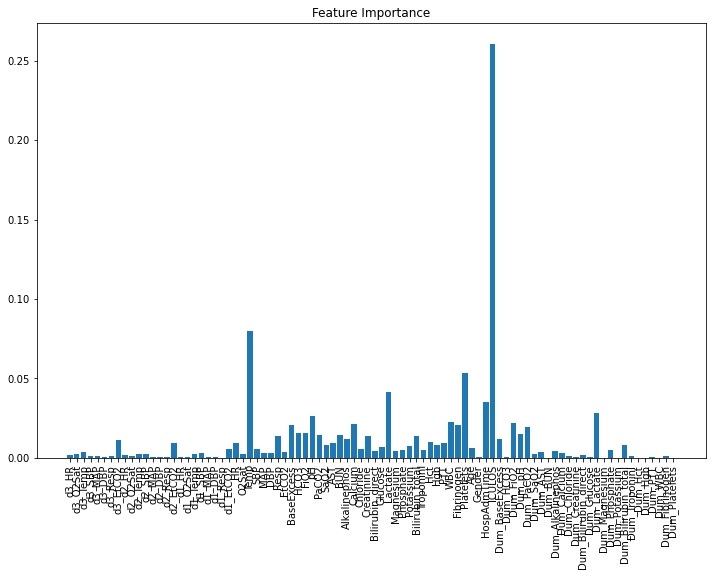

In [29]:
#Plot Feature Importance 
Plot_Feat_Imp(RFC_,Var_names,pd,np,plt,(12,8))

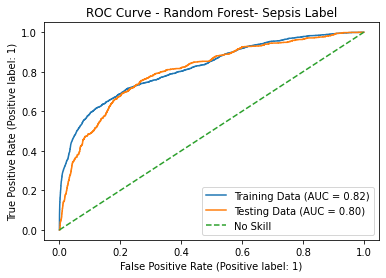

In [30]:
#Plot ROC Curve
_=plt.axes()
plot_roc_curve(RFC_,X_train,y_train_sepsis,ax=_,name='Training Data')
plot_roc_curve(RFC_,X_test,y_test_sepsis,ax=_,name='Testing Data')
_.plot([0,1],[0,1],label='No Skill',linestyle='--')
_.legend()
_.set_title('ROC Curve - Random Forest- Sepsis Label')
plt.show()

Best Train Threshold=0.072172, F-Score=0.319
Best Test Threshold=0.128001, F-Score=nan
Train AUC: 0.262 Test AUC: 0.091


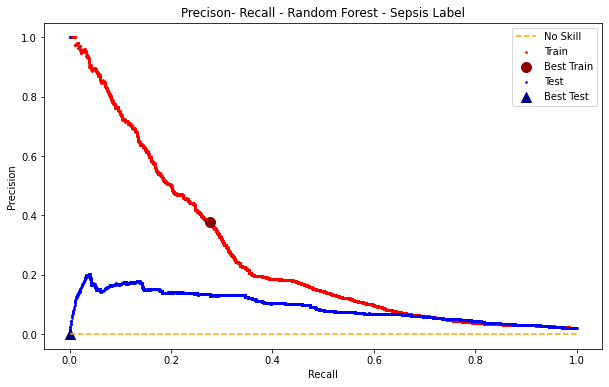

In [31]:
#Plot Precison-Recall Curve, determine optimal cutoff value
title='Precison- Recall - Random Forest - Sepsis Label'
prob=Plot_PR(RFC_,X_train,y_train_sepsis,X_test,y_test_sepsis,title,auc,precision_recall_curve,np,plt,(10,6))

In [32]:
#Return Classification Report of testing data with optimal train probability threshold
q=RFC_.predict_proba(X_test)[:,1]
y_pred_test_new=[1 if i>prob else 0 for i in q]
print(classification_report(y_test_sepsis,y_pred_test_new))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98     57984
           1       0.14      0.21      0.17      1116

    accuracy                           0.96     59100
   macro avg       0.56      0.59      0.57     59100
weighted avg       0.97      0.96      0.96     59100



In [33]:
#Return Confusion Matrix of testing data with optimal train probability threshold
print(confusion_matrix(y_test_sepsis,y_pred_test_new))

[[56537  1447]
 [  880   236]]


In [ ]:
#Return Confusion Matrix of testing data with optimal train probability threshold
print(confusion_matrix(y_test_sepsis,y_pred_test_new))

### Pre Sepsis

In [34]:
#Find optimal random forest parameters for modeling Pre Sepsis
start = datetime.now()
RFC = RandomForestClassifier(random_state=42,max_features='sqrt',n_estimators=500)
max_depth = [x**2 for x in range(2,10)]
min_samples_split = [4,7,16]
min_samples_leaf = [4,7,16]
distributions = {'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}
RFC_RS=RandomizedSearchCV(RFC,distributions,random_state=42,n_iter=20,cv=folds.split(X_train),n_jobs=-1,scoring='f1')
search_RFC_Sepsis=RFC_RS.fit(X_train, y_train_pre)
best_dict=search_RFC_Sepsis.best_params_
end = datetime.now()
time_elapsed(start,end)
search_RFC_Sepsis.best_params_

This process took 01 Hours 18 Minutes 54 Seconds 


{'min_samples_split': 7, 'min_samples_leaf': 7, 'max_depth': 4}

In [35]:
#Create Model
RFC_=RandomForestClassifier(n_estimators=1000, min_samples_split=best_dict['min_samples_split'],
min_samples_leaf=best_dict['min_samples_leaf'], max_features='sqrt', max_depth=best_dict['max_depth'],
random_state=42,n_jobs=-1)
RFC_.fit(X_train,y_train_pre)

RandomForestClassifier(max_depth=4, max_features='sqrt', min_samples_leaf=7,
                       min_samples_split=7, n_estimators=1000, n_jobs=-1,
                       random_state=42)

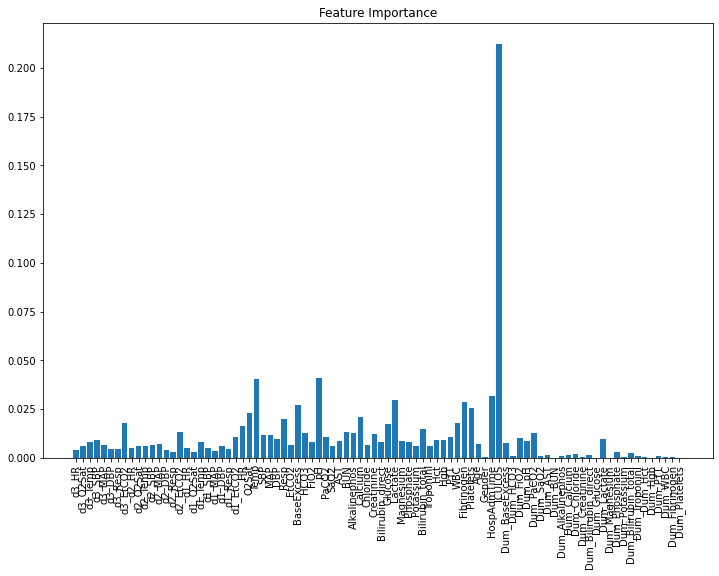

In [36]:
#Plot Feature Importance 
Plot_Feat_Imp(RFC_,Var_names,pd,np,plt,(12,8))

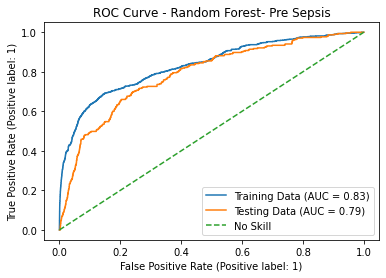

In [37]:
#Plot ROC Curve
_=plt.axes()
plot_roc_curve(RFC_,X_train,y_train_pre,ax=_,name='Training Data')
plot_roc_curve(RFC_,X_test,y_test_pre,ax=_,name='Testing Data')
_.plot([0,1],[0,1],label='No Skill',linestyle='--')
_.legend()
_.set_title('ROC Curve - Random Forest- Pre Sepsis')
plt.show()

Best Train Threshold=0.023947, F-Score=0.215
Best Test Threshold=0.027024, F-Score=nan
Train AUC: 0.129 Test AUC: 0.022


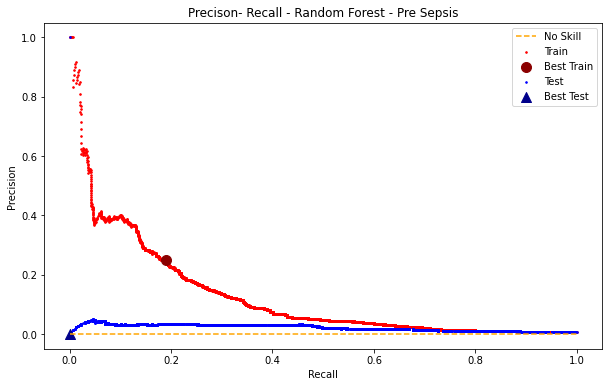

In [38]:
#Plot Precison-Recall Curve, determine optimal cutoff value
title='Precison- Recall - Random Forest - Pre Sepsis'
prob=Plot_PR(RFC_,X_train,y_train_pre,X_test,y_test_pre,title,auc,precision_recall_curve,np,plt,(10,6))

In [39]:
#Return Classification Report of testing data with optimal train probability threshold
q=RFC_.predict_proba(X_test)[:,1]
y_pred_test_new=[1 if i>prob else 0 for i in q]
print(classification_report(y_test_pre,y_pred_test_new))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     58797
           1       0.04      0.05      0.04       303

    accuracy                           0.99     59100
   macro avg       0.52      0.52      0.52     59100
weighted avg       0.99      0.99      0.99     59100



In [40]:
#Return Confusion Matrix of testing data with optimal train probability threshold
print(confusion_matrix(y_test_pre,y_pred_test_new))

[[58442   355]
 [  288    15]]


## 5.4. Gradient Boosting <a class="anchor" id="5.4.GradientBoosting"></a>

### Sepsis Label

In [13]:
#Randomized search for Gradient Boost Classifier, Sepsis Label
start = datetime.now()
GB = GradientBoostingClassifier(random_state=42,max_features='sqrt')
max_depth = [3,5]
n_estimators=[50,100,200]
learning_rate=[1/(10**i) for i in range(2,7)]
distributions = {'max_depth': max_depth,'learning_rate': learning_rate, 'n_estimators': n_estimators}
GB_RS=GridSearchCV(GB,distributions,cv=folds.split(X_train),n_jobs=-1,scoring='f1')
search_GB_Sepsis=GB_RS.fit(X_train,y_train_sepsis)
end = datetime.now()
time_elapsed(start,end)
best_dict=search_GB_Sepsis.best_params_
search_GB_Sepsis.best_params_

This process took 00 Hours 13 Minutes 49 Seconds 


{'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200}

In [14]:
#Create Model
start = datetime.now()
GB_=GradientBoostingClassifier(learning_rate=best_dict['learning_rate'],
n_estimators=best_dict['n_estimators'], max_features='sqrt', max_depth=best_dict['max_depth'], random_state=42)
GB_.fit(X_train,y_train_sepsis)
end = datetime.now()
time_elapsed(start,end)

This process took 00 Hours 00 Minutes 37 Seconds 


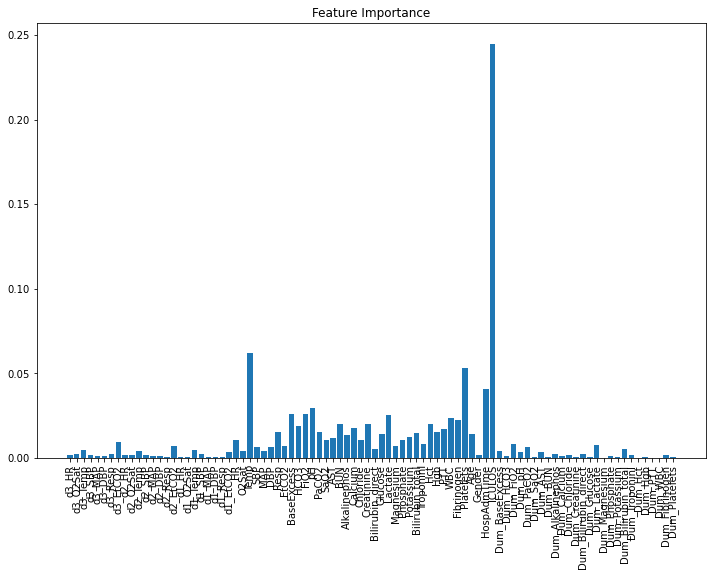

In [15]:
#Plot Feature Importance 
Plot_Feat_Imp(GB_,Var_names,pd,np,plt,(12,8))

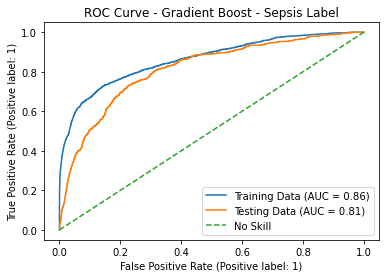

In [16]:
#Plot ROC Curve
_=plt.axes()
plot_roc_curve(GB_,X_train,y_train_sepsis,ax=_,name='Training Data')
plot_roc_curve(GB_,X_test,y_test_sepsis,ax=_,name='Testing Data')
_.plot([0,1],[0,1],label='No Skill',linestyle='--')
_.legend()
_.set_title('ROC Curve - Gradient Boost - Sepsis Label')
plt.show()

Best Train Threshold=0.099898, F-Score=0.415
Best Test Threshold=0.448583, F-Score=nan
Train AUC: 0.4 Test AUC: 0.097


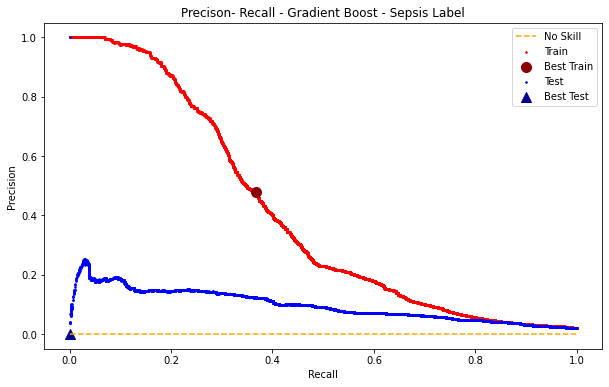

In [17]:
#Plot Precison-Recall Curve, determine optimal cutoff value
title='Precison- Recall - Gradient Boost - Sepsis Label'
prob=Plot_PR(GB_,X_train,y_train_sepsis,X_test,y_test_sepsis,title,auc,precision_recall_curve,np,plt,(10,6))

In [18]:
#Return Classification Report of testing data with optimal train probability threshold
q=GB_.predict_proba(X_test)[:,1]
y_pred_test_new=[1 if i>prob else 0 for i in q]  
print(classification_report(y_test_sepsis,y_pred_test_new))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98     57984
           1       0.15      0.23      0.18      1116

    accuracy                           0.96     59100
   macro avg       0.57      0.60      0.58     59100
weighted avg       0.97      0.96      0.96     59100



In [19]:
#Return Confusion Matrix of testing data with optimal train probability threshold
print(confusion_matrix(y_test_sepsis,y_pred_test_new))

[[56481  1503]
 [  854   262]]


### Pre Sepsis

In [20]:
#Randomized search for Gradient Boost Classifier, Pre Sepsis
start = datetime.now()
GB = GradientBoostingClassifier(random_state=42,max_features='sqrt')
max_depth = [3,5]
n_estimators=[50,100,200]
learning_rate=[1/(10**i) for i in range(2,7)]
distributions = {'max_depth': max_depth,'learning_rate': learning_rate, 'n_estimators': n_estimators}
GB_RS=GridSearchCV(GB,distributions,cv=folds.split(X_train),n_jobs=-1,scoring='f1')
search_GB_Sepsis=GB_RS.fit(X_train,y_train_pre)
end = datetime.now()
time_elapsed(start,end)
best_dict=search_GB_Sepsis.best_params_
search_GB_Sepsis.best_params_

This process took 00 Hours 13 Minutes 02 Seconds 


{'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50}

In [55]:
#CV Testing Results
a=search_GB_Sepsis.cv_results_['split0_test_score']
b=search_GB_Sepsis.cv_results_['split1_test_score']
c=search_GB_Sepsis.cv_results_['split2_test_score']
d=search_GB_Sepsis.cv_results_['split3_test_score']
e=np.concatenate((a,b,c,d))
print('The  f1 test scores from cross validation had a mean value of {} and a standard deviation of {}.'.format(round(np.mean(e),4),round(np.std(e),4)))

The  f1 test scores from cross validation had a mean value of 0.0 and a standard deviation of 0.0.


In [21]:
#Create Model
start = datetime.now()
GB_=GradientBoostingClassifier(learning_rate=best_dict['learning_rate'],
n_estimators=best_dict['n_estimators'], max_features='sqrt', max_depth=best_dict['max_depth'], random_state=42)
GB_.fit(X_train,y_train_pre)
end = datetime.now()
time_elapsed(start,end)

This process took 00 Hours 00 Minutes 05 Seconds 


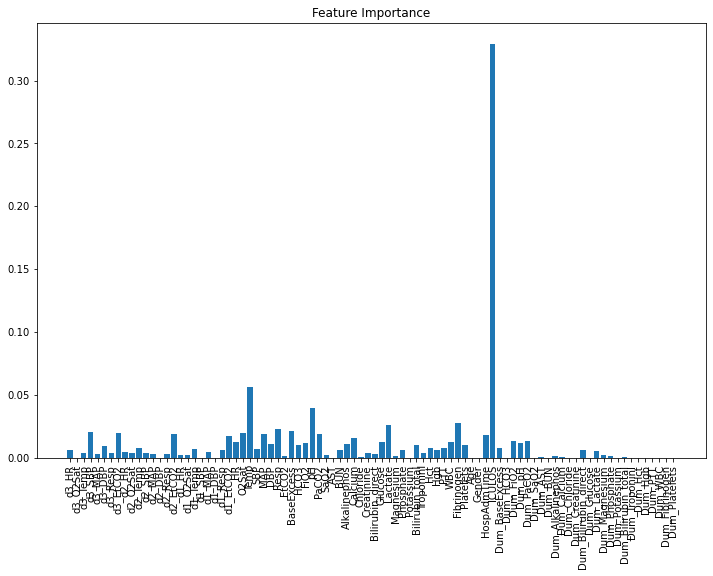

In [22]:
#Plot Feature Importance 
Plot_Feat_Imp(GB_,Var_names,pd,np,plt,(12,8))

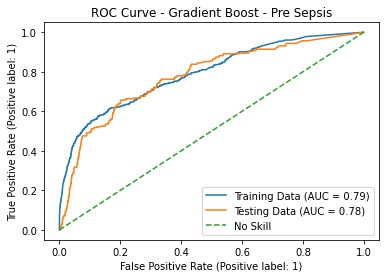

In [23]:
#Plot ROC Curve
_=plt.axes()
plot_roc_curve(GB_,X_train,y_train_pre,ax=_,name='Training Data')
plot_roc_curve(GB_,X_test,y_test_pre,ax=_,name='Testing Data')
_.plot([0,1],[0,1],label='No Skill',linestyle='--')
_.legend()
_.set_title('ROC Curve - Gradient Boost - Pre Sepsis')
plt.show()

Best Train Threshold=0.012621, F-Score=0.158
Best Test Threshold=0.014038, F-Score=nan
Train AUC: 0.114 Test AUC: 0.02


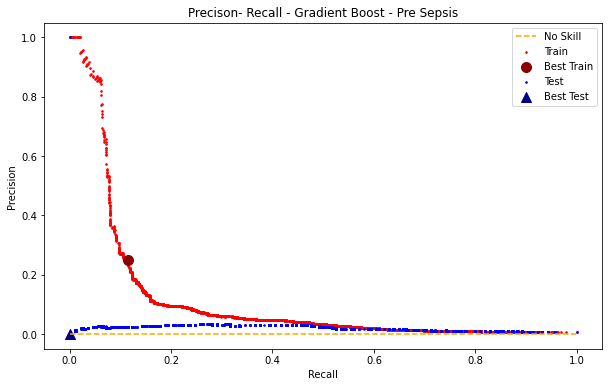

In [24]:
#Plot Precison-Recall Curve, determine optimal cutoff value
title='Precison- Recall - Gradient Boost - Pre Sepsis'
prob=Plot_PR(GB_,X_train,y_train_pre,X_test,y_test_pre,title,auc,precision_recall_curve,np,plt,(10,6))

In [25]:
#Return Classification Report of testing data with optimal train probability threshold
q=GB_.predict_proba(X_test)[:,1]
y_pred_test_new=[1 if i>prob else 0 for i in q]
print(classification_report(y_test_pre,y_pred_test_new))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     58797
           1       0.01      0.01      0.01       303

    accuracy                           0.99     59100
   macro avg       0.50      0.50      0.50     59100
weighted avg       0.99      0.99      0.99     59100



In [26]:
#Return Confusion Matrix of testing data with optimal train probability threshold
print(confusion_matrix(y_test_pre,y_pred_test_new))

[[58482   315]
 [  300     3]]


## 5.5. SVM <a class="anchor" id="5.5.SVM"></a>

### Sepsis Label

In [27]:
#Find logsitic regression parameters for modeling Sepsis Label
start = datetime.now()
svm_ = SVC(class_weight='balanced')
C=[1/(10**i) for i in range(0,7)]
distributions = {'C': C,}
SVM_RS=GridSearchCV(svm_,distributions,cv=folds.split(X_train),n_jobs=-1,scoring='f1')
search_SVM_GS=SVM_RS.fit(X_train, y_train_sepsis)
end = datetime.now()
time_elapsed(start,end)
best_dict=search_SVM_GS.best_params_
search_SVM_GS.best_params_

This process took 06 Hours 34 Minutes 21 Seconds 


{'C': 1.0}

In [53]:
#CV Testing Results
a=search_SVM_GS.cv_results_['split0_test_score']
b=search_SVM_GS.cv_results_['split1_test_score']
c=search_SVM_GS.cv_results_['split2_test_score']
d=search_SVM_GS.cv_results_['split3_test_score']
e=np.concatenate((a,b,c,d))
print('The  f1 test scores from cross validation had a mean value of {} and a standard deviation of {}.'.format(round(np.mean(e),4),round(np.std(e),4)))

The  f1 test scores from cross validation had a mean value of 0.055 and a standard deviation of 0.0292.


In [28]:
#Create Model
SVM_=SVC(class_weight='balanced',C=best_dict['C'])
SVM_.fit(X_train,y_train_sepsis)

SVC(class_weight='balanced')

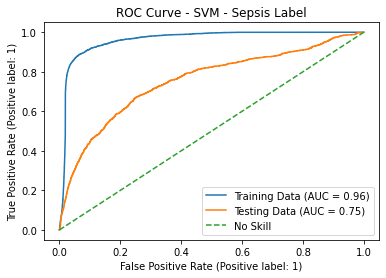

In [56]:
#Plot ROC Curve
_=plt.axes()
plot_roc_curve(SVM_,X_train,y_train_sepsis,ax=_,name='Training Data')
plot_roc_curve(SVM_,X_test,y_test_sepsis,ax=_,name='Testing Data')
_.plot([0,1],[0,1],label='No Skill',linestyle='--')
_.legend()
_.set_title('ROC Curve - SVM - Sepsis Label')
plt.show()

In [57]:
#Return Classification Report of testing data 
y_pred_test_new=SVM_.predict(X_test)
print(classification_report(y_test_sepsis,y_pred_test_new))

              precision    recall  f1-score   support

           0       0.99      0.85      0.91     57984
           1       0.06      0.53      0.11      1116

    accuracy                           0.84     59100
   macro avg       0.53      0.69      0.51     59100
weighted avg       0.97      0.84      0.90     59100



In [58]:
#Return Confusion Matrix of testing data 
print(confusion_matrix(y_test_sepsis,y_pred_test_new))

[[49144  8840]
 [  524   592]]


# 6. Modeling with SMOTE <a class="anchor" id="6.ModelingwithSMOTE"></a>

In [12]:
from imblearn.over_sampling import SMOTE
smote=SMOTE(sampling_strategy='minority')
X_train,y_train_pre=smote.fit_resample(X_train,y_train_pre)

In [13]:
#Fit Min-Max Scaler to X_train data, transform X_train and X_test data
MM_scale=MinMaxScaler()
MM_scale.fit(X_train)
X_train=MM_scale.transform(X_train)
X_test=MM_scale.transform(X_test)

## 6.1. Logistic Regression - SMOTE <a class="anchor" id="6.1.LogisticRegression-SMOTE"></a>

###  Pre Sepsis

In [ ]:
#Make Logistic Regression Model with optimized C
clf=LogisticRegression(max_iter=1000,C=1)
clf.fit(X_train,y_train_pre)

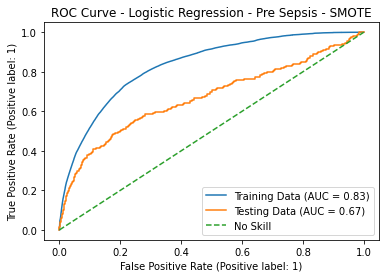

In [26]:
#Plot ROC Curve
_=plt.axes()
plot_roc_curve(clf,X_train,y_train_pre,ax=_,name='Training Data')
plot_roc_curve(clf,X_test,y_test_pre,ax=_,name='Testing Data')
_.plot([0,1],[0,1],label='No Skill',linestyle='--')
_.legend()
_.set_title('ROC Curve - Logistic Regression - Pre Sepsis - SMOTE')
plt.show()

Best Train Threshold=0.414868, F-Score=0.770
Best Test Threshold=0.999398, F-Score=nan
Train AUC: 0.824 Test AUC: 0.02


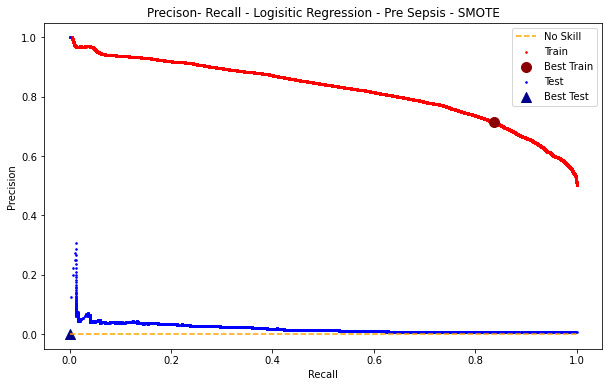

In [27]:
#Plot Precison-Recall Curve, determine optimal cutoff value
title='Precison- Recall - Logisitic Regression - Pre Sepsis - SMOTE'
prob=Plot_PR(clf,X_train,y_train_pre,X_test,y_test_pre,title,auc,precision_recall_curve,np,plt,(10,6))

In [28]:
#Return Classification Report of testing data with optimal train probability threshold
q=clf.predict_proba(X_test)[:,1]
y_pred_test_new=[1 if i>prob else 0 for i in q]
print(classification_report(y_test_sepsis,y_pred_test_new))

              precision    recall  f1-score   support

           0       0.99      0.64      0.78     57984
           1       0.03      0.64      0.06      1116

    accuracy                           0.64     59100
   macro avg       0.51      0.64      0.42     59100
weighted avg       0.97      0.64      0.76     59100



In [29]:
#Return Confusion Matrix of testing data with optimal train probability threshold
print(confusion_matrix(y_test_sepsis,y_pred_test_new))

[[37037 20947]
 [  402   714]]


## 6.2. Gradient Boosting - SMOTE <a class="anchor" id="6.2.GradientBoosting-SMOTE"></a>

### Pre- Sepsis

In [37]:
#Create Model
start = datetime.now()
GB_=GradientBoostingClassifier(learning_rate=0.0001, n_estimators=100, max_features='sqrt', max_depth=3, random_state=42)
GB_.fit(X_train,y_train_pre)
end = datetime.now()
time_elapsed(start,end)

This process took 00 Hours 00 Minutes 46 Seconds 


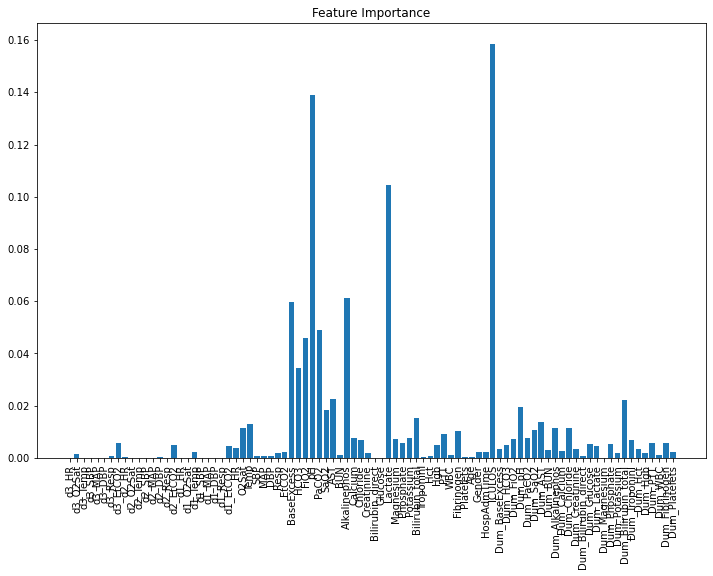

In [38]:
#Plot Feature Importance 
Plot_Feat_Imp(GB_,Var_names,pd,np,plt,(12,8))

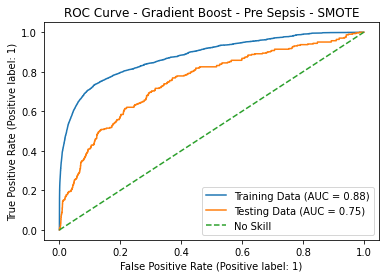

In [39]:
#Plot ROC Curve
_=plt.axes()
plot_roc_curve(GB_,X_train,y_train_pre,ax=_,name='Training Data')
plot_roc_curve(GB_,X_test,y_test_pre,ax=_,name='Testing Data')
_.plot([0,1],[0,1],label='No Skill',linestyle='--')
_.legend()
_.set_title('ROC Curve - Gradient Boost - Pre Sepsis - SMOTE')
plt.show()

Best Train Threshold=0.499980, F-Score=0.799
Best Test Threshold=0.502077, F-Score=nan
Train AUC: 0.897 Test AUC: 0.022


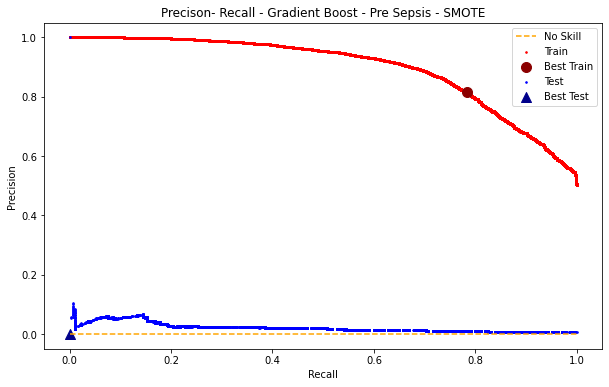

In [40]:
#Plot Precison-Recall Curve, determine optimal cutoff value
title='Precison- Recall - Gradient Boost - Pre Sepsis - SMOTE'
prob=Plot_PR(GB_,X_train,y_train_pre,X_test,y_test_pre,title,auc,precision_recall_curve,np,plt,(10,6))

In [41]:
#Return Classification Report of testing data with optimal train probability threshold
q=GB_.predict_proba(X_test)[:,1]
y_pred_test_new=[1 if i>prob else 0 for i in q]
print(classification_report(y_test_pre,y_pred_test_new))

              precision    recall  f1-score   support

           0       1.00      0.81      0.89     58797
           1       0.01      0.56      0.03       303

    accuracy                           0.81     59100
   macro avg       0.51      0.68      0.46     59100
weighted avg       0.99      0.81      0.89     59100



In [42]:
#Return Confusion Matrix of testing data with optimal train probability threshold
print(confusion_matrix(y_test_pre,y_pred_test_new))

[[47484 11313]
 [  134   169]]


# 7. Modeling - All Data <a class="anchor" id="7.Modeling-AllData"></a>

## 7.1. Logistic Regression - All Data <a class="anchor" id="7.1.LogisticRegression-AllData"></a>

### Sepsis Label

In [13]:
#Make Logistic Regression Model with optimized C
clf=LogisticRegression(max_iter=1000,C=1)
clf.fit(X_train,y_train_sepsis)

LogisticRegression(C=1, max_iter=1000)

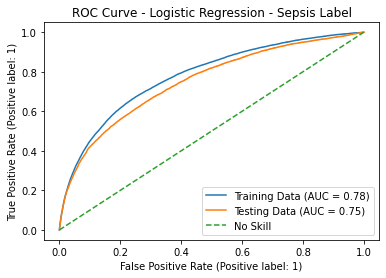

In [14]:
#Plot ROC Curve
_=plt.axes()
plot_roc_curve(clf,X_train,y_train_sepsis,ax=_,name='Training Data')
plot_roc_curve(clf,X_test,y_test_sepsis,ax=_,name='Testing Data')
_.plot([0,1],[0,1],label='No Skill',linestyle='--')
_.legend()
_.set_title('ROC Curve - Logistic Regression - Sepsis Label')
plt.show()

Best Train Threshold=0.590408, F-Score=nan
Best Test Threshold=0.070698, F-Score=0.159
Train AUC: 0.083 Test AUC: 0.079


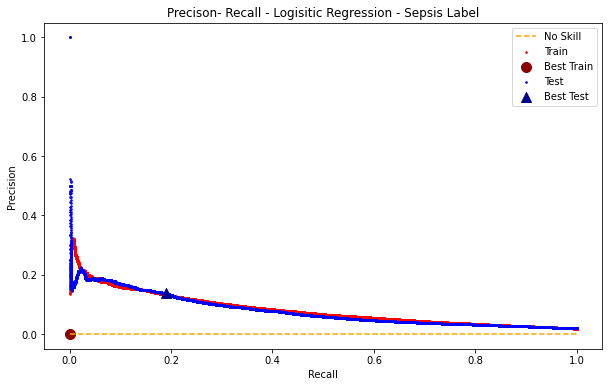

In [15]:
#Plot Precison-Recall Curve, determine optimal cutoff value
title='Precison- Recall - Logisitic Regression - Sepsis Label'
prob=Plot_PR(clf,X_train,y_train_sepsis,X_test,y_test_sepsis,title,auc,precision_recall_curve,np,plt,(10,6))

In [16]:
#Return Classification Report of testing data with optimal train probability threshold
q=clf.predict_proba(X_test)[:,1]
y_pred_test_new=[1 if i>prob else 0 for i in q]
print(classification_report(y_test_sepsis,y_pred_test_new))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99    378144
           1       1.00      0.00      0.00      7213

    accuracy                           0.98    385357
   macro avg       0.99      0.50      0.50    385357
weighted avg       0.98      0.98      0.97    385357



In [17]:
#Return Confusion Matrix of testing data with optimal train probability threshold
print(confusion_matrix(y_test_sepsis,y_pred_test_new))

[[378144      0]
 [  7212      1]]


## 7.2. Gradient Boosting - All Data <a class="anchor" id="7.2.GradientBoosting-AllData"></a>

### Sepsis Label

In [18]:
best_dict={'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200}

In [19]:
#Create Model
start = datetime.now()
GB_=GradientBoostingClassifier(learning_rate=best_dict['learning_rate'],
n_estimators=best_dict['n_estimators'], max_features='sqrt', max_depth=best_dict['max_depth'], random_state=42)
GB_.fit(X_train,y_train_sepsis)
end = datetime.now()
time_elapsed(start,end)

This process took 00 Hours 05 Minutes 39 Seconds 


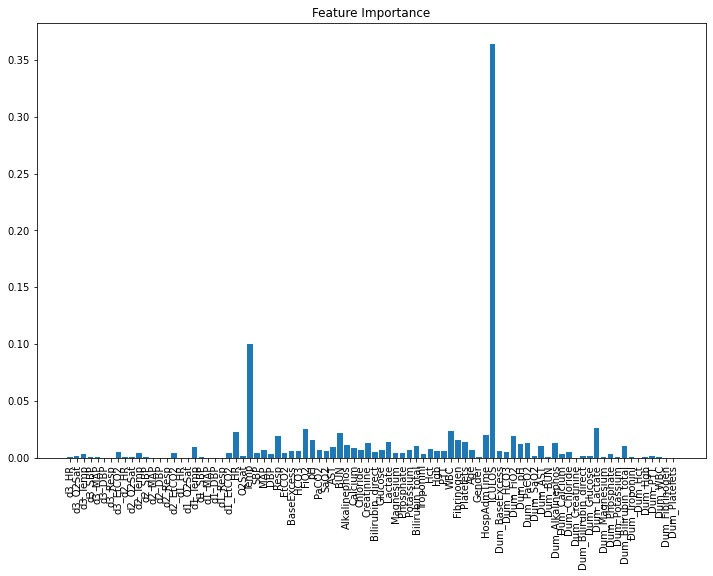

In [20]:
#Plot Feature Importance 
Plot_Feat_Imp(GB_,Var_names,pd,np,plt,(12,8))

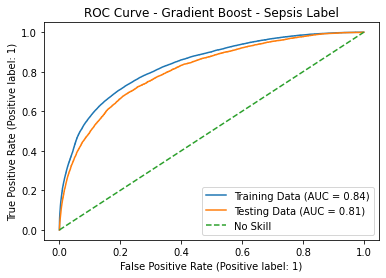

In [21]:
#Plot ROC Curve
_=plt.axes()
plot_roc_curve(GB_,X_train,y_train_sepsis,ax=_,name='Training Data')
plot_roc_curve(GB_,X_test,y_test_sepsis,ax=_,name='Testing Data')
_.plot([0,1],[0,1],label='No Skill',linestyle='--')
_.legend()
_.set_title('ROC Curve - Gradient Boost - Sepsis Label')
plt.show()

Best Train Threshold=0.089514, F-Score=0.239
Best Test Threshold=0.338641, F-Score=nan
Train AUC: 0.182 Test AUC: 0.117


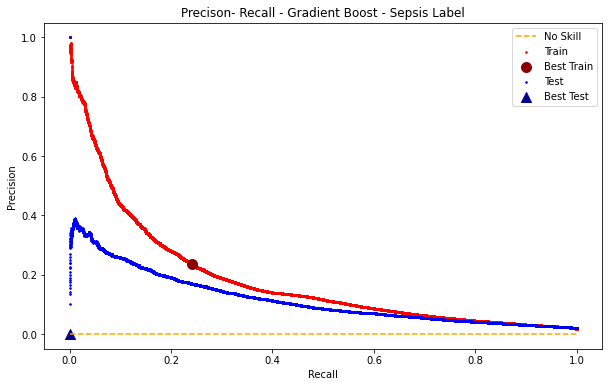

In [22]:
#Plot Precison-Recall Curve, determine optimal cutoff value
title='Precison- Recall - Gradient Boost - Sepsis Label'
prob=Plot_PR(GB_,X_train,y_train_sepsis,X_test,y_test_sepsis,title,auc,precision_recall_curve,np,plt,(10,6))

In [23]:
#Return Classification Report of testing data with optimal train probability threshold
q=GB_.predict_proba(X_test)[:,1]
y_pred_test_new=[1 if i>prob else 0 for i in q]  
print(classification_report(y_test_sepsis,y_pred_test_new))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99    378144
           1       0.21      0.17      0.18      7213

    accuracy                           0.97    385357
   macro avg       0.60      0.58      0.59    385357
weighted avg       0.97      0.97      0.97    385357



In [24]:
#Return Confusion Matrix of testing data with optimal train probability threshold
print(confusion_matrix(y_test_sepsis,y_pred_test_new))

[[373626   4518]
 [  6018   1195]]
